# Cifar10 上的 ReNet18

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import torch
from torch import nn
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存

In [2]:
import torch_book
print(torch_book.__version__)

0.0.8


{mod}`torchvision` 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

```{note}
将 `conv1` 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

In [3]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)

加载数据集：

In [4]:
data = Cifar10(batch_size = 64)
train_iter = data.train_loader()
test_iter = data.val_loader()

Files already downloaded and verified
Files already downloaded and verified


打印每层输出尺寸：

In [5]:
for xs, _ in train_iter:
    break

for name, m in model.named_children():
    xs = m(xs)
    print(name, tuple(xs.shape))
    if name=="avgpool":
        xs = torch.flatten(xs, 1)

conv1 (64, 64, 32, 32)
bn1 (64, 64, 32, 32)
relu (64, 64, 32, 32)
maxpool (64, 64, 32, 32)
layer1 (64, 64, 32, 32)
layer2 (64, 128, 16, 16)
layer3 (64, 256, 8, 8)
layer4 (64, 512, 4, 4)
avgpool (64, 512, 1, 1)
fc (64, 10)


由于替换了卷积运算，会造成精度损失，需要微调模型：

In [7]:
classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)

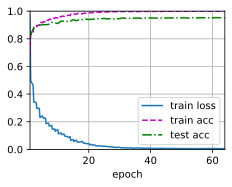

In [8]:
num_epochs = 64
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [10]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:0"))
test_acc

0.9522

保存模型：

In [11]:
torch.save(classifier.mod.state_dict(),
           'params/resnet18_cifar10_relu.h5')

## Cutout Cifar10 训练

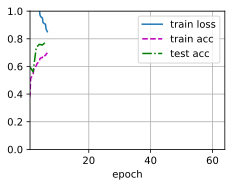

In [13]:
from torch_book.transforms.cutout import Cutout

num_epochs = 64
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
data = Cifar10(batch_size = 64, cutout=Cutout(16, 8))
train_iter = data.train_loader()
test_iter = data.val_loader()
classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

## 性能度量

In [12]:
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()       
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        classifier.mod(inputs)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2023-05-19 10:01:19 3447593:3447593 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference       -11.70%  -25126.000us        99.98%     214.774ms     214.774ms       0.000us         0.00%       1.437ms       1.437ms             1  
                                      aten::convolution         0.15%     323.000us        86.67%     186.188ms       9.309ms       0.000us         0.00%       1.288ms      64.400us            20  
         

STAGE:2023-05-19 10:01:19 3447593:3447593 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-19 10:01:19 3447593:3447593 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
